# Product Recognition on Store Shelves
## Computer Vision and Image Processing - Exam Project
### Nicholas Antonio Carroll, nicholas.carroll@studio.unibo.it - Laura Mazzuca, laura.mazzuca@studio.unibo.it

## Step B: Multiple Instance Detection


### Local Invariant Features with General Hough Transform Star Model

###### Offline phase
1. **Keypoint Detection**: Identify salient repeatable points (Keypoints) in model and scene images (with SIFT).
2. **Compute Descriptor**: 
    - compute barycentre **Pc** of all keypoints
    - compute voting vector **Vi** for each keypoint **Ki** with position **Pi** as ***Vi = Pc -Pi***

###### Online phase
3. **Scene Keypoint Detection**: Match point from scene and model according to joining vectors detection.
4. **Match with Query Images**:
5. **GHT - vote for barycentre position**
4. **Position Estimation**: Estimate the position of the object in the scene image by using the votes for barycentre and then applying the transformation matrix resulting from the previous step to the angles of the bounding box

## Environment setup

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  #Connect to google drive folder, needed only if running notebook on colab
  from google.colab import drive
  drive.mount('/content/gdrive')

If working in colab install the correct version of opencv

In [3]:
if IN_COLAB:
  !pip install opencv-contrib-python==4.5.4.60

In [4]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt

if IN_COLAB:
  scenes_location = 'gdrive/MyDrive/shelf-product-recognition/images/scenes/'
  models_location = 'gdrive/MyDrive/shelf-product-recognition/images/models/'
else:
  scenes_location = 'images/scenes/'
  models_location = 'images/models/'

scenes=['m1.png','m2.png','m3.png', 'm4.png','m5.png']
models=['0.jpg','1.jpg','11.jpg','19.jpg','24.jpg','25.jpg','26.jpg']

for i in range(len(scenes)):
  scenes[i] = scenes_location+scenes[i]

for i in range(len(models)):
  models[i] = models_location+models[i]

Load all the query images:

In [5]:
img_query = []
i=0
for p in models:
    img_query.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) # queryImage

## Offline Phase

### 1. Keypoint Detection
Initialize the SIFT detector object in the following way:


In [6]:
# Initiate SIFT detector
sift = cv2.SIFT_create(nOctaveLayers=5, contrastThreshold=0.11, sigma=1.4)


Then we need to find keypoints. We will use _detect_ method of the SIFT detector object. Let us find the keypoints of all the query images:

In [7]:
# find the keypoints and descriptors with SIFT
kp_query = []
for img in img_query:
    kp_query.append(sift.detect(img))

### 2. Keypoints Description 

Compute for each keypoint a unique description usually based on the nearby pixels (descriptor support). We will use the SIFT descriptor.

In [8]:
#Calculates the barycenter of the keypoints of an image
def calculate_barycentre(keyPoints):
    x=0
    y=0
    for kp in keyPoints:
        x += kp.pt[0]
        y += kp.pt[1]
    x = x/len(keyPoints)
    y = y/len(keyPoints)

    return (x,y)

In [9]:
#The extended keypoint class contains the coordinates of the point, angle, size, descriptor and the voting parameter
class ExtendedKeyPoint:
    def __init__(self, kp, pc, desc):
        self.kp = kp #kp contains in itself point, angle, size
        self.desc = desc
        #difference between barycenter and the point returns the Vi vector
        self.vi = (pc[0] - kp.pt[0], pc[1] - kp.pt[1])


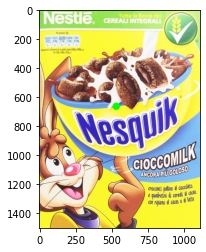

barycentre in (530.17, 662.88)


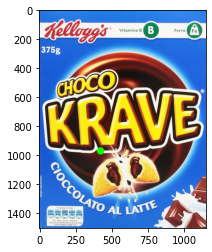

barycentre in (422.04, 969.91)


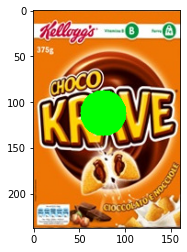

barycentre in (76.69, 112.05)


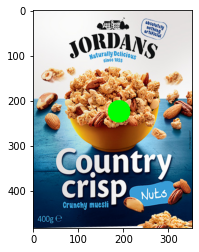

barycentre in (190.18, 224.95)


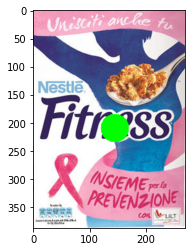

barycentre in (145.84, 209.36)


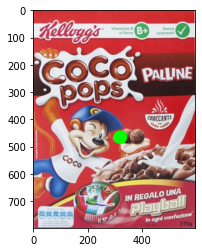

barycentre in (318.77, 465.46)


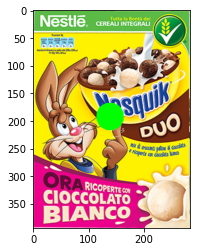

barycentre in (139.68, 192.40)


In [34]:
# Describing keypoints for query and train images
des_query = np.empty(len(img_query), dtype=object)
kp_query_extended = []
img_query_rgb = []

for i in range(len(img_query)):
    kp_query[i], des_query[i] = sift.compute(img_query[i], kp_query[i])
    #pc = calculate_barycentre_from_shape(img_query[i].shape)
    pc=calculate_barycentre(kp_query[i])
    kp_query_extended.append([])
    for k in range(len(kp_query[i])):
        kp_query_extended[i].append(ExtendedKeyPoint(kp_query[i][k], pc, des_query[i][k]))
    ##print rgb image with barycentre
    img_query_rgb.append(cv2.cvtColor(cv2.imread(models[i]), cv2.COLOR_BGR2RGB)) # trainImage
    img_query_rgb[i] = cv2.circle(img_query_rgb[i], np.int32(pc), radius=25, color=(0,255,0), thickness=-1)
    plt.imshow(img_query_rgb[i])
    plt.show()
    print(f'barycentre in ({pc[0]:.2f}, { pc[1]:.2f})')
    ################################

## Online Phase

Load the train images:

In [11]:
img_train = []
for p in scenes:
    img_train.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) # trainImage

### 3. Scene Keypoints Detection
Let us find the keypoints for the train images:

In [12]:
kp_train = []
for img in img_train:
    kp_train.append(sift.detect(img))

In [13]:
# Describing keypoints for query and train images
des_train = np.empty(len(img_train), dtype=object)

for i in range(len(img_train)):
    kp_train[i], des_train[i] = sift.compute(img_train[i], kp_train[i])

### 4. Match with Query Images
We compute the matches with the usual KD Tree and choose good keypoints with Lowe's ratio

In [14]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=500 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 500)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
matches_per_image = np.empty(len(img_train), dtype=object)
i = 0 #index for the train images

for des_t in des_train: #for each scene
    matches_per_image[i] = [] #create a list that will hold the matches wrt each model image
    for des_q in des_query: #for each query image
        matches_per_image[i].append(flann.knnMatch(des_q,des_t,k=2)) #compute at most 2 matches per keypoint matches
    i = i+1

In [15]:
good = np.empty(len(img_train), dtype=object)
i=0
j=0
for mat_img in matches_per_image:#for each list of matches wrt a train image
    good[i] = np.empty(len(img_query), dtype=object)
    j=0
    for matches in mat_img: # for each list of matches related to the train image j
        good[i][j] = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good[i][j].append(m)
        j=j+1
    i=i+1

### 5. GHT - cast votes for barycentre

Here compute the Hough Space points, which are points defined by:
- Position ```pt```: which is the barycentre pointed by the matched keypoint
- Scale ```s```: which is the ratio between the matched keypoint size and the source keypoint size
- Angle ```phi```: which is the difference between the matched keypoint angle and the source keypoint angle

Right after computing them, we quantize them in intervals of position through a dictionary, where the keys are the positions divided by the ```QUANTIZATION``` parameter and then rounded with the ```floor``` function and the value is the list of barycentres that fall into that interval.

This phase starts clusterizing the barycentres as well thanks to the closeness measurement.

In [16]:
class HoughSpacePoint:
    def __init__(self, query_ext_kp, matched_kp):
        self.src_kp = query_ext_kp.kp
        self.dest_kp = matched_kp
        self.s = matched_kp.size/query_ext_kp.kp.size
        self.phi = matched_kp.angle-query_ext_kp.kp.angle
        #the angle is not used in the function below because it gives worse results
#        self.R = np.array([[np.cos(self.phi), - np.sin(self.phi)],
#                           [np.sin(self.phi), np.cos(self.phi)]])
#        self.rot_vi = np.matmul(self.R, np.array([query_ext_kp.vi[0],query_ext_kp.vi[1]]))
#        self.pt = (matched_kp.pt[0]+self.s*self.rot_vi[0], matched_kp.pt[1]+self.s*self.rot_vi[1])
        self.pt = (matched_kp.pt[0]+self.s*query_ext_kp.vi[0], matched_kp.pt[1]+self.s*query_ext_kp.vi[1])


In [59]:
barycenteres_votes = np.empty(len(img_train), dtype=object)
i=0
QUANTIZATION=100
for mat_img in matches_per_image:#for each list of matches related to an image wrt a train image
    j = 0
    barycenteres_votes[i] = np.empty(len(img_query), dtype=dict)
    for matches in mat_img: # for each list of matches related to the query image j
        barycenteres_votes[i][j] = dict()
        img_shape = np.shape(img_train[i])
        for m in good[i][j]:
            bary_vote = HoughSpacePoint(kp_query_extended[j][m.queryIdx],kp_train[i][m.trainIdx]) 
            
            if bary_vote.pt[0] >= 0 and bary_vote.pt[1] >= 0 and bary_vote.pt[0] <= img_shape[1] and bary_vote.pt[1] <= img_shape[0]:
                q_pt = (int(math.floor(bary_vote.pt[0]/QUANTIZATION)), int(math.floor(bary_vote.pt[1]/QUANTIZATION)))
                
                if q_pt not in barycenteres_votes[i][j]:            
                    barycenteres_votes[i][j][q_pt] = list()
                barycenteres_votes[i][j][q_pt].append(bary_vote)
        j+=1
    i+=1

Then we get the intervals where at least ```THRESHOLD``` barycenters were added.

In [60]:
def get_max_len_list(dict_list, th):
    max_len = th
    max_k = []
    
    for k in dict_list:
        l = len(dict_list[k])
        if l > th:
            max_k.append(k)  
    return max_k

[GHT] looking for barycentres with at least 15 vote(s)...

[scene images/scenes/m1.png]

[image images/models/0.jpg] 1 barycentre area hypothesis:
	 (9, 1) with 45 barycenters:
[image images/models/1.jpg] 0 barycentre area hypothesis:
[image images/models/11.jpg] 0 barycentre area hypothesis:
[image images/models/19.jpg] 0 barycentre area hypothesis:
[image images/models/24.jpg] 3 barycentre area hypothesis:
	 (2, 2) with 20 barycenters:
	 (5, 2) with 34 barycenters:
	 (1, 2) with 25 barycenters:
[image images/models/25.jpg] 1 barycentre area hypothesis:
	 (12, 2) with 151 barycenters:
[image images/models/26.jpg] 1 barycentre area hypothesis:
	 (9, 2) with 182 barycenters:


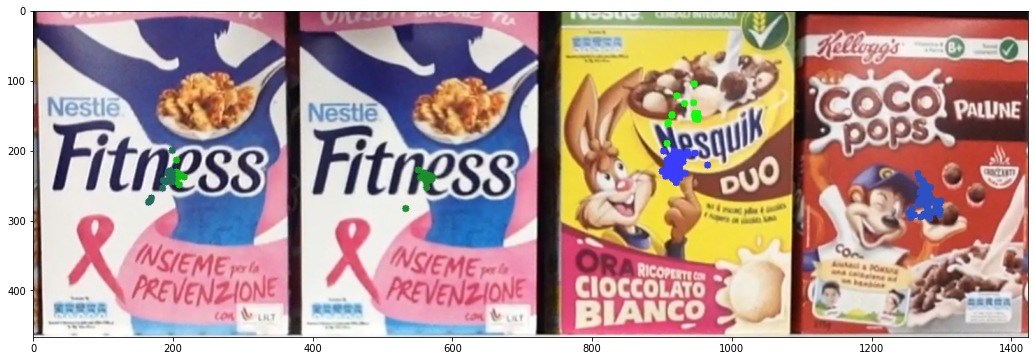

[scene images/scenes/m2.png]

[image images/models/0.jpg] 1 barycentre area hypothesis:
	 (1, 2) with 198 barycenters:
[image images/models/1.jpg] 3 barycentre area hypothesis:
	 (8, 3) with 44 barycenters:
	 (11, 3) with 25 barycenters:
	 (4, 3) with 20 barycenters:
[image images/models/11.jpg] 2 barycentre area hypothesis:
	 (8, 2) with 22 barycenters:
	 (5, 2) with 26 barycenters:
[image images/models/19.jpg] 0 barycentre area hypothesis:
[image images/models/24.jpg] 0 barycentre area hypothesis:
[image images/models/25.jpg] 0 barycentre area hypothesis:
[image images/models/26.jpg] 1 barycentre area hypothesis:
	 (1, 3) with 64 barycenters:


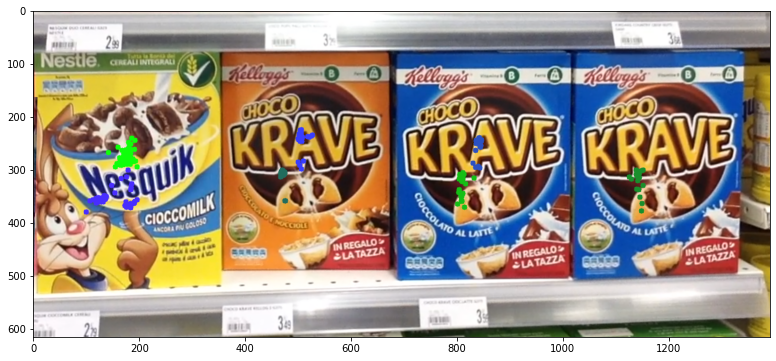

[scene images/scenes/m3.png]

[image images/models/0.jpg] 2 barycentre area hypothesis:
	 (1, 1) with 23 barycenters:
	 (2, 1) with 45 barycenters:
[image images/models/1.jpg] 1 barycentre area hypothesis:
	 (8, 2) with 17 barycenters:
[image images/models/11.jpg] 0 barycentre area hypothesis:
[image images/models/19.jpg] 1 barycentre area hypothesis:
	 (12, 1) with 135 barycenters:
[image images/models/24.jpg] 0 barycentre area hypothesis:
[image images/models/25.jpg] 3 barycentre area hypothesis:
	 (8, 2) with 16 barycenters:
	 (5, 2) with 60 barycenters:
	 (9, 2) with 50 barycenters:
[image images/models/26.jpg] 4 barycentre area hypothesis:
	 (2, 1) with 16 barycenters:
	 (1, 2) with 178 barycenters:
	 (2, 2) with 19 barycenters:
	 (1, 1) with 24 barycenters:


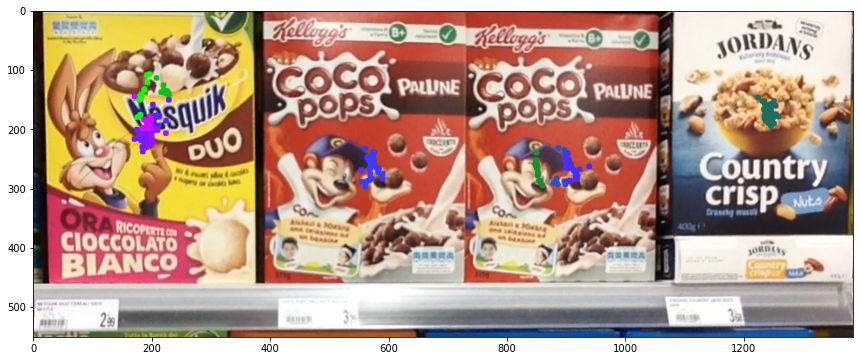

[scene images/scenes/m4.png]

[image images/models/0.jpg] 1 barycentre area hypothesis:
	 (9, 1) with 42 barycenters:
[image images/models/1.jpg] 0 barycentre area hypothesis:
[image images/models/11.jpg] 0 barycentre area hypothesis:
[image images/models/19.jpg] 0 barycentre area hypothesis:
[image images/models/24.jpg] 2 barycentre area hypothesis:
	 (5, 2) with 39 barycenters:
	 (1, 2) with 25 barycenters:
[image images/models/25.jpg] 2 barycentre area hypothesis:
	 (12, 2) with 53 barycenters:
	 (16, 2) with 32 barycenters:
[image images/models/26.jpg] 2 barycentre area hypothesis:
	 (9, 1) with 102 barycenters:
	 (9, 2) with 43 barycenters:


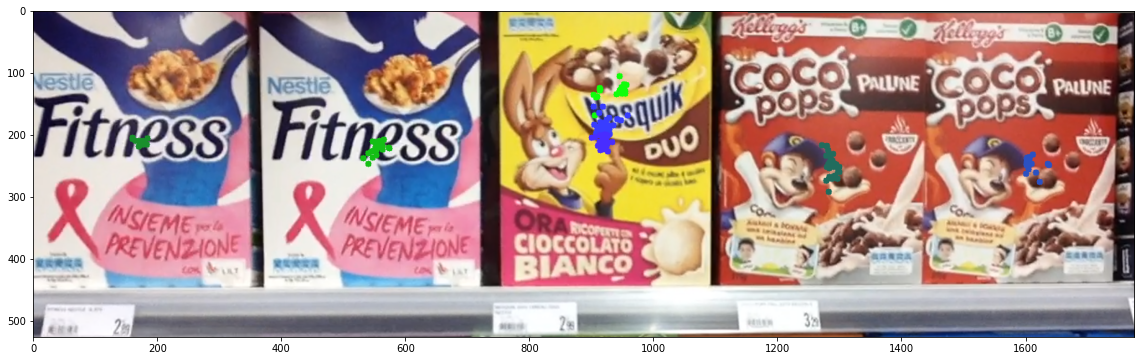

[scene images/scenes/m5.png]

[image images/models/0.jpg] 0 barycentre area hypothesis:
[image images/models/1.jpg] 3 barycentre area hypothesis:
	 (4, 7) with 28 barycenters:
	 (1, 7) with 18 barycenters:
	 (7, 7) with 18 barycenters:
[image images/models/11.jpg] 2 barycentre area hypothesis:
	 (1, 7) with 19 barycenters:
	 (4, 7) with 20 barycenters:
[image images/models/19.jpg] 1 barycentre area hypothesis:
	 (9, 1) with 106 barycenters:
[image images/models/24.jpg] 0 barycentre area hypothesis:
[image images/models/25.jpg] 2 barycentre area hypothesis:
	 (2, 2) with 43 barycenters:
	 (5, 2) with 39 barycenters:
[image images/models/26.jpg] 0 barycentre area hypothesis:


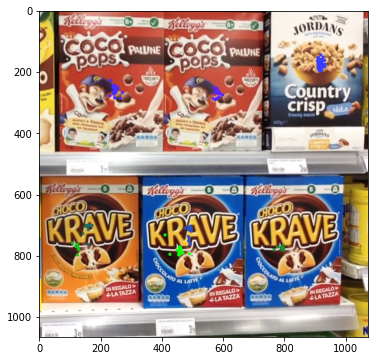

In [61]:
img_train_rgb = []
for p in scenes:
    img_train_rgb.append(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) # trainImage

THRESHOLD = 15
max_bary_keys = []

print("[GHT] looking for barycentres with at least {} vote(s)...\n".format(THRESHOLD))
for i in range(len(img_train)):
    color = (15, 255, 10)
    max_bary_keys.append([])
    print("[scene {}]\n".format(scenes[i]))
    for j in range(len(img_query)):
        max_bary_keys[i].append([])
        max_bary_keys[i][j] = get_max_len_list(barycenteres_votes[i][j], THRESHOLD)
        print("[image {}] {} barycentre area hypothesis:".format(models[j], len(max_bary_keys[i][j])))
    #print("\n")

# print barycenters on images
        for pt in max_bary_keys[i][j]:
            print("\t {} with {} barycenters:".format(pt, len(barycenteres_votes[i][j][pt])))
            for bary_vote in barycenteres_votes[i][j][pt]:
                img_train_rgb[i] = cv2.circle(img_train_rgb[i], np.int32(bary_vote.pt),radius=5, color=color, thickness=-1)
            color = (color[0]*1.3, color[1]*0.75, color[2]*2.1)
    plt.figure(figsize = (40,6))
    plt.imshow(img_train_rgb[i])
    plt.show()
############################

### 6. Position Estimation


Then can use  **Random Sample Consensus (RANSAC)**, an algorithm to fit a parametric model to noisy data. In our case estimate an homography from good matches while identifying and discarding the wrong ones.

In [123]:
class Box:
    def __init__(self, dst):
        self.dst = dst
        self.centre = dst.mean(axis=0)[0]
        self.corners = [(pt[0][0],pt[0][1]) for pt in dst]
        self.h = (self.corners[2][1] + self.corners[1][1] - self.corners[0][1] - self.corners[3][1]) / 2
        self.w = (self.corners[3][0] + self.corners[2][0] - self.corners[1][0] - self.corners[0][0]) / 2


In [124]:
def check_points_closeness(pt1, pt2, th):
    return (np.sqrt(np.power(pt1[0]- pt2[0],2) + np.power(pt1[1] - pt2[1],2))) <= th
     

In [125]:
def check_overlap(boxes, j, pt, th):
    if j == 0 and len(centers[j]) == 0:
        return -1, pt
   # print('examining potential overlaps for center = {}'.format(centers[j][pt]))

    for img in range(j+1): #includes also current image
        if boxes[img] is not None:
            for cur_pt in boxes[img]:
                if boxes[img][cur_pt] is not None:
    #                print('\tconfronting with image {} with center = {} in area {}'.format(models[img],centers[img][cur_pt], cur_pt))
                    if check_points_closeness(boxes[j][pt].centre, boxes[img][cur_pt].centre, th):
     #                   print('OVERLAPS')
                        return img, cur_pt
    return -1, pt

scene 0

Product 0 - 0 instances found.
Product 1 - 0 instances found.
Product 2 - 0 instances found.
Product 3 - 0 instances found.
Product 4 - 2 instances found.
	Instance 1 in (551.24, 218.87), width: 335px, height: 491px 
	Instance 2 in (185.99, 216.66), width: 350px, height: 503px 
Product 5 - 1 instances found.
	Instance 1 in (1261.59, 234.88), width: 314px, height: 445px 
Product 6 - 1 instances found.
	Instance 1 in (921.08, 218.07), width: 333px, height: 487px 


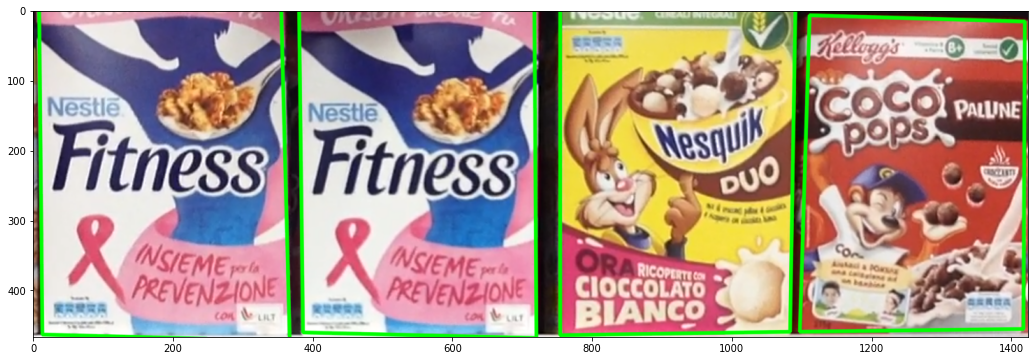



scene 1

Product 0 - 1 instances found.
	Instance 1 in (178.97, 300.51), width: 344px, height: 449px 
Product 1 - 2 instances found.
	Instance 1 in (848.14, 259.44), width: 312px, height: 411px 
	Instance 2 in (1180.02, 252.57), width: 301px, height: 407px 
Product 2 - 1 instances found.
	Instance 1 in (511.42, 252.70), width: 307px, height: 403px 
Product 3 - 0 instances found.
Product 4 - 0 instances found.
Product 5 - 0 instances found.
Product 6 - 0 instances found.


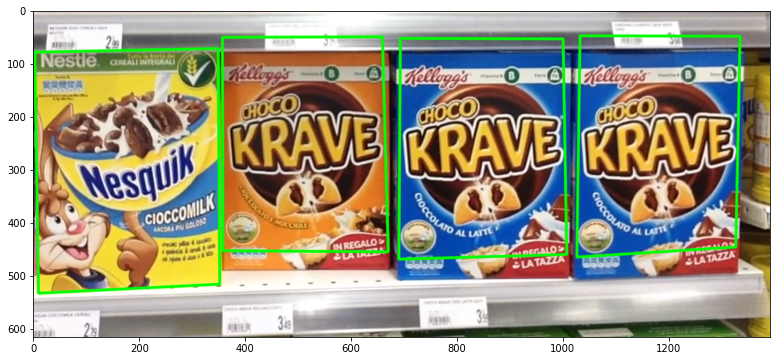



scene 2

Product 0 - 0 instances found.
Product 1 - 0 instances found.
Product 2 - 0 instances found.
Product 3 - 1 instances found.
	Instance 1 in (1232.95, 189.71), width: 296px, height: 383px 
Product 4 - 0 instances found.
Product 5 - 2 instances found.
	Instance 1 in (558.69, 222.79), width: 336px, height: 458px 
	Instance 2 in (889.45, 225.68), width: 320px, height: 441px 
Product 6 - 1 instances found.
	Instance 1 in (195.35, 206.22), width: 354px, height: 506px 


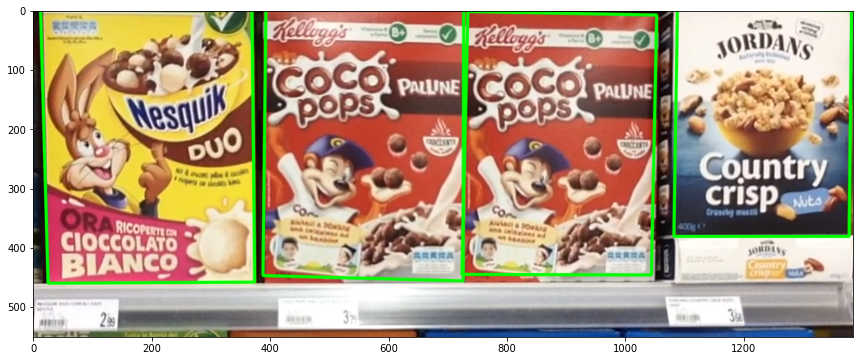



scene 3

Product 0 - 0 instances found.
Product 1 - 0 instances found.
Product 2 - 0 instances found.
Product 3 - 0 instances found.
Product 4 - 2 instances found.
	Instance 1 in (540.83, 196.58), width: 349px, height: 501px 
	Instance 2 in (163.91, 195.28), width: 362px, height: 510px 
Product 5 - 2 instances found.
	Instance 1 in (1271.55, 210.37), width: 324px, height: 452px 
	Instance 2 in (1588.26, 212.14), width: 307px, height: 434px 
Product 6 - 1 instances found.
	Instance 1 in (921.78, 195.41), width: 341px, height: 494px 


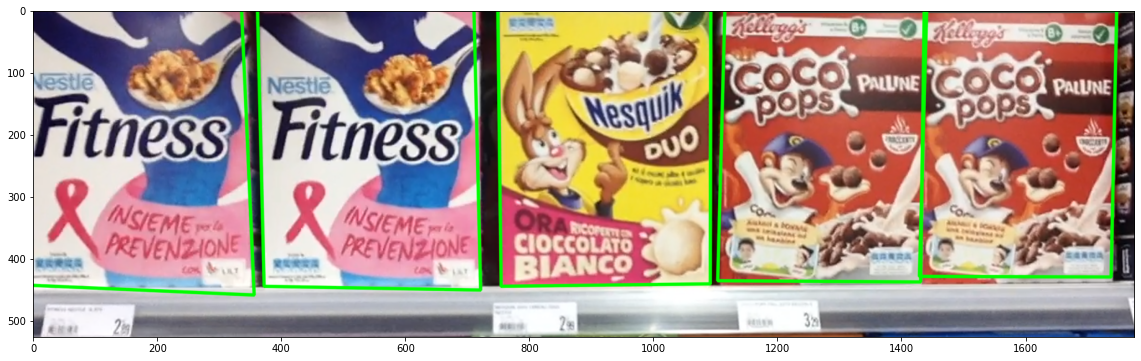



scene 4

Product 0 - 0 instances found.
Product 1 - 2 instances found.
	Instance 1 in (501.19, 720.87), width: 314px, height: 412px 
	Instance 2 in (832.02, 716.32), width: 301px, height: 411px 
Product 2 - 1 instances found.
	Instance 1 in (163.97, 706.09), width: 306px, height: 399px 
Product 3 - 1 instances found.
	Instance 1 in (909.14, 190.52), width: 296px, height: 384px 
Product 4 - 0 instances found.
Product 5 - 2 instances found.
	Instance 1 in (236.72, 277.26), width: 365px, height: 561px 
	Instance 2 in (564.63, 289.74), width: 358px, height: 562px 
Product 6 - 0 instances found.


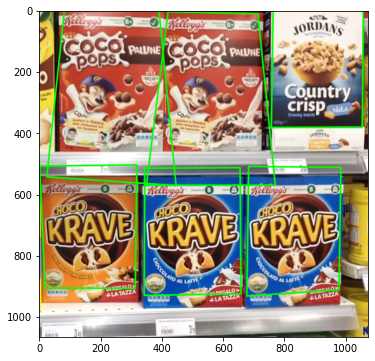

In [127]:
# Checking if we found enough matching
img_train_rgb = []
for p in scenes:
    img_train_rgb.append(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) # trainImage

matchesMask = np.empty(len(img_train), dtype=object)
boxes = np.empty(len(img_train), dtype=object)
color = (0, 255, 0)
CLOSENESS=150

for i in range(len(img_train)):
    print("scene {}\n".format(i))
    cur_kp_train = kp_train[i]
    matchesMask[i] = np.empty(len(img_query), dtype=object)
    boxes[i] = np.empty(len(img_query), dtype=dict)
    for j in range(len(img_query)):
        boxes[i][j] = dict()
        for pt in max_bary_keys[i][j]:
            cur_kp_query = barycenteres_votes[i][j][pt]
            # building the corrspondences arrays of good matches
            src_pts = np.float32([ bary.src_kp.pt for bary in barycenteres_votes[i][j][pt] ]).reshape(-1,1,2)
            dst_pts = np.float32([ bary.dest_kp.pt for bary in barycenteres_votes[i][j][pt] ]).reshape(-1,1,2)
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Corners of the query image
            h,w = img_query[j].shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            boxes[i][j][pt] = Box(cv2.perspectiveTransform(pts,M))
            #check if in the same scene there are overlapping boxes from different imgs
        
            overlap_idx, overlap_pt = check_overlap(boxes[i], j, pt, CLOSENESS)
            if overlap_idx > -1 and ((overlap_idx != j) or (overlap_idx == j and overlap_pt != pt)):
                if len(barycenteres_votes[i][j][pt]) >= len(barycenteres_votes[i][overlap_idx][overlap_pt]):
                    del boxes[i][overlap_idx][overlap_pt]
                else:
                    del boxes[i][j][pt]                    
            
    for j in range(len(img_query)):
        if boxes[i][j] is not None:
            print('Product {} - {} instances found.'.format(j, len(dst[i][j])))
            k=1
            for pt in boxes[i][j]:
                if boxes[i][j][pt] is not None:
                    current = boxes[i][j][pt]
                    print(f'\tInstance {k} in ({current.centre[0]:.2f}, { current.centre[1]:.2f}), width: {current.w:.0f}px, height: {current.h:.0f}px ')
                    # Drawing the bounding box
                    k+=1
                    img_train_rgb[i] = cv2.polylines(img_train_rgb[i],[np.int32(boxes[i][j][pt].dst)],True,color,3, cv2.LINE_AA)
    plt.figure(figsize = (40,6))
    plt.imshow(img_train_rgb[i])
    plt.show()
    print("\n")
